# In this file, we show the predictability of the fitted surrogate model based on piecewise affine function (PWA) used in PWAS, and GP with different kernels used in BO

* Here, we focus on problems with mixed-variables and discontinuous functions, which we argue that PWA function can have a better fit when the number of samples are limited (usually the case for problems within chemistry domain)
* 1-D and 2-D examples were selected for better visualization

In [1]:
import numpy as np

## # Example 1, 1-D Discontinuous nonlinear function (continuous variables)
def fun_1(x):
    result = np.zeros_like(x)  # Initialize result array
    
    result[(x>=-5) & (x <= 1)] = x[(x>=-5) & (x <= 1)]**2 - 3
    result[(x>1) & (x <= 4)] = .5* x[(x>1) & (x <= 4)] +31 
    result[(x>4) & (x <= 10)] = -.2 * (x[(x>4) & (x <= 10)] - 7)**3 
    
    return result

# Example 2, 2-D Discontinuous nonlinear function (mixed variables)
def fun_2(x, y):
    result = np.zeros_like(x)  # Initialize result array
    # Compute result based on the value of y
    result = (-(x+.5) ** 2 + 2 * x + 1)*(y==0)
    result += (-x - 100) *(y==1)
    result += ((x-1) ** 3) *(y==2)
    result += (12 * x +50) *(y==3)
    return result

f_1 = lambda x: fun_1(x)
f_2 = lambda x,y: fun_2(x,y)
f_4 = lambda x,y: fun_2(x,y) # However, here y can only take integer values

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
import time # for tic-toc

np.random.seed(0)  # for reproducibility

# Generate training samples
N = 70
test_size = 0.2

N_predict = 10000 # to plot the figure

save_fig = True

function_to_test = "fun_2"

if function_to_test == "fun_1":
    xmin, xmax = -5, 10
    f = f_1
    nx = 1
    # Define x range (continuous variable)
    x_values = np.linspace(xmin,xmax,N)
    
    X_ = x_values.reshape(-1,1)
    Y = f(x_values) 
    Y_ = np.array(Y.ravel())
    
 
elif function_to_test == "fun_2":
    xmin, xmax = -5, 5
    ymin, ymax = 0, 3  # integer
    
    def generate_pattern_array(N, min_val, max_val):
        basic_sequence = np.arange(min_val, max_val + 1)
        repeated_sequence = np.tile(basic_sequence, (N // len(basic_sequence)) + 1)
        result_array = repeated_sequence[:N]
        return result_array.reshape(-1,1)
    
    nx = 2
    f = f_2
    # Define x range (continuous variable)
    x_values = np.linspace(xmin,xmax,N).reshape(-1,1)
    y_values = generate_pattern_array(N, ymin, ymax)
    X_ = np.hstack((x_values,y_values))
    Y = f(x_values, y_values) 
    Y_ = np.array(Y.ravel())

 
else:
    errstr = "Please define a new problem or use the pre-defined problems"
    print(errstr)
    import sys
    sys.exit(1)

### Plot the analytical expression

<Figure size 800x800 with 0 Axes>

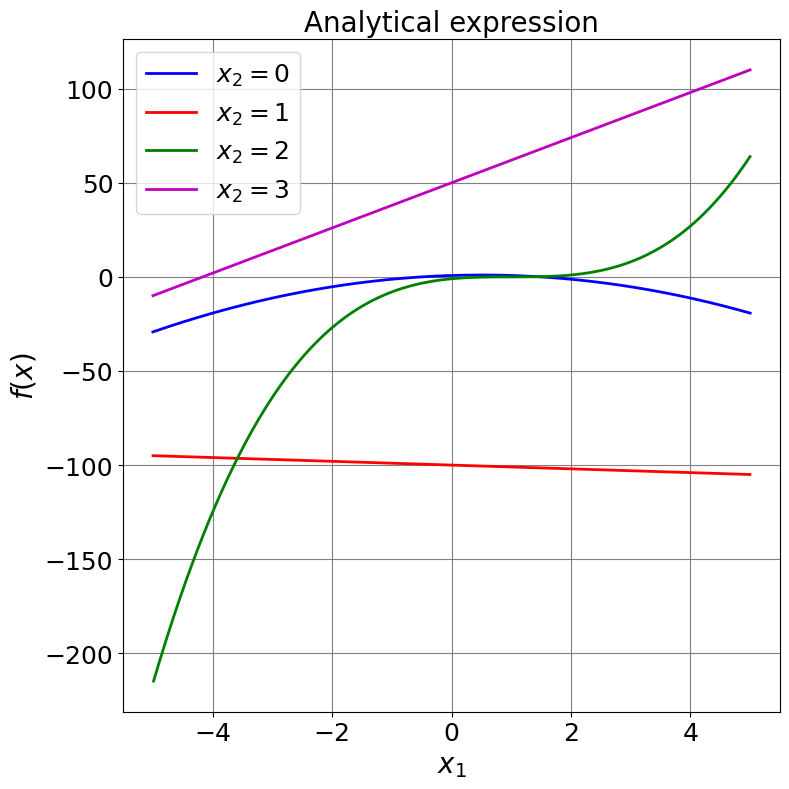

In [3]:
# Plot
plt.close('all')

if function_to_test in ["fun_1", "fun_3"]:
    fig = plt.figure(figsize=(8, 8))
    
    x_plot = np.linspace(xmin, xmax, N_predict)
    Y_plot = f(x_plot) 

    plt.plot(x_plot, Y_plot, 'b-',linewidth=2)

    plt.xlabel(r'$x$', fontsize=20)
    plt.ylabel(r'$f(x)$', fontsize=20)
    plt.title('Analytical expression', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, color='gray')
    plt.box(True)
    plt.tight_layout()
    # fig.savefig("parc_analytical_fun.pdf")
    # fig.savefig("parc_analytical_fun.png")
    # plt.show(
elif function_to_test in ["fun_2"]:
    
    fig = plt.figure(figsize=(8, 8))
    
    fig = plt.figure(figsize=(8, 8))
    
    X1_plot = np.linspace(xmin, xmax, N_predict)
    X2_plot = np.random.randint(0, 4, N_predict)
        
    Y_plot = f(X1_plot, X2_plot)
    # Plot for y = 0
    plt.plot(X1_plot[X2_plot==0], Y_plot[X2_plot==0], 'b-', label=r'$x_2 = 0$', linewidth=2)
    # Plot for y = 1
    plt.plot(X1_plot[X2_plot==1], Y_plot[X2_plot==1], 'r-', label=r'$x_2 = 1$', linewidth=2)
    # Plot for y = 2
    plt.plot(X1_plot[X2_plot==2], Y_plot[X2_plot==2], 'g-', label=r'$x_2 = 2$', linewidth=2)
    # Plot for y = 3
    plt.plot(X1_plot[X2_plot==3], Y_plot[X2_plot==3], 'm-', label=r'$x_2 = 3$', linewidth=2)
    
    plt.xlabel(r'$x_1$', fontsize=20)
    plt.ylabel(r'$f(x)$', fontsize=20)
    plt.title('Analytical expression', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, color='gray')
    plt.box(True)
    plt.legend(fontsize=18)
    plt.tight_layout()
    # fig.savefig("parc_analytical_fun.pdf")
    # fig.savefig("parc_analytical_fun.png")
    # plt.show()

        
plt.tight_layout()
if save_fig:
    fig.savefig(f"{function_to_test}_parc_analytical_fun.pdf")
    fig.savefig(f"{function_to_test}_parc_analytical_fun.png")
plt.show()

### Fit with Piecewise affine surrogate
Reference file: https://github.com/bemporad/PyPARC/blob/main/examples/parc_example_1.py

In [4]:
from pyparc.parc import PARC
import math

K = min(10, N * test_size)

separation = 'Softmax'
# separation='Voronoi'
sigma = 1
alpha = 1.0e-4
beta = 1.0e-3
softmax_maxiter = 100000
maxiter = 15

# xmin = xmin
# xmax = x_max
# ymin = 0
# ymax = 3

cpu_time = {}

nyc = 1  # number of numeric outputs
categorical = False  # whether the output is categorical

if function_to_test in ["fun_2"]:  # perform one-hot encoder first
    from sklearn.preprocessing import OneHotEncoder

    X_continuous = x_values.ravel()
    # One-hot encode the categorical variable
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    X_categorical_encoded = encoder.fit_transform(y_values.ravel().reshape(-1, 1))
    X_ = np.hstack([X_continuous.reshape(-1, 1), X_categorical_encoded])

# Get random split of training/test data
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=test_size, shuffle=True)

tic = time.process_time()
predictor = PARC(K=K, alpha=alpha, sigma=sigma, separation=separation, maxiter=maxiter,
                 cost_tol=1e-4, min_number=1, fit_on_partition=True,
                 beta=beta, verbose=0)

# Y_hat, delta_hat = predictor.predict(X_test) # predict targets

predictor.fit(X_train, Y_train, categorical, weights=np.ones(1))
toc = time.process_time()
cpu_time["PWAS"] = toc - tic

print("Model fitting time required (%f)", (cpu_time["PWAS"]))

score_train = predictor.score(X_train, Y_train)  # compute R2 score on training data
score_test = predictor.score(X_test, Y_test)  # compute R2 score on test data

C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model fitting time required (%f) 0.921875


C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecat

In [5]:
# print the score
print("\nResults:\n")
print("Training data: %6.2f %%" % (score_train[0] * 100))
print("Test data:     %6.2f %%" % (score_test[0] * 100))
print("--------------------\n")


Results:

Training data:  99.98 %
Test data:      85.55 %
--------------------


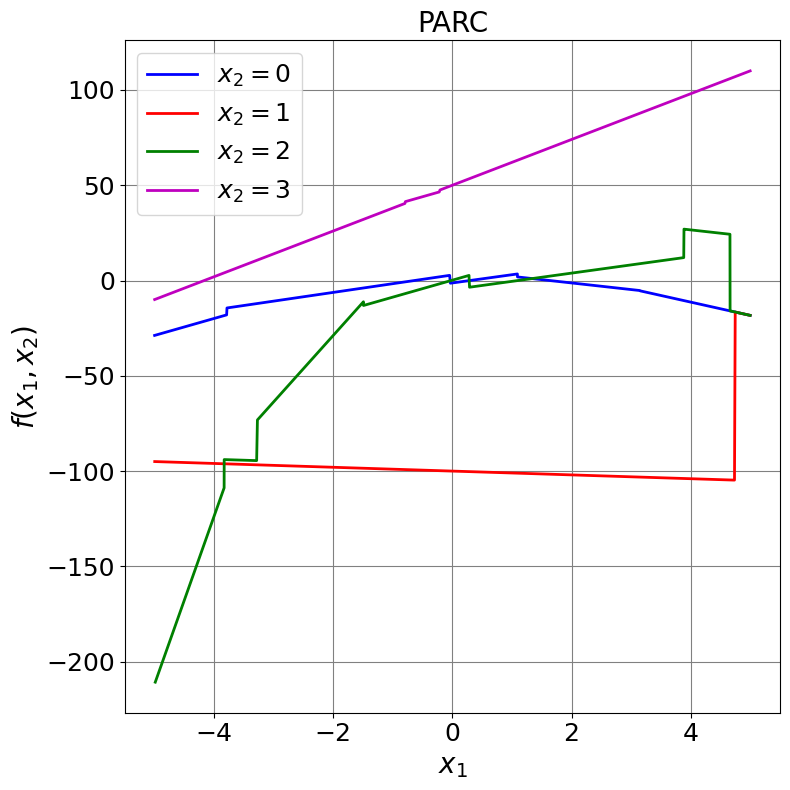

In [6]:
# Plot predictions

if function_to_test in ["fun_1"]:
    
    zpwl, _ = predictor.predict(x_plot.reshape(x_plot.size, 1))
    zpwl = zpwl.reshape(x_plot.shape)
    
    
    fig = plt.figure(figsize=(8,8))

    plt.plot(x_plot, zpwl, 'b-', linewidth=2)

    plt.xlabel(r'$x$', fontsize=20)
    plt.ylabel(r'$f(x)$', fontsize=20)
    plt.title('PARC', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, color='gray')
    plt.box(True)
    
elif function_to_test in ["fun_2"]:
    
    # One-hot encode the categorical variable
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    X_categorical_encoded_toPred = encoder.fit_transform(X2_plot.ravel().reshape(-1,1))
    # Combine continuous and categorical variables into a single dataset
    X_topredict = np.hstack([X1_plot.reshape(-1,1), X_categorical_encoded_toPred])
    
    # X_topredict = np.transpose(np.array([X1_topredict.ravel(), X2_topredict.ravel()]))
    
    zpwl, _ = predictor.predict(X_topredict)
    zpwl = zpwl.reshape(X_topredict[:,0].shape)
    
    
    fig = plt.figure(figsize=(8,8))

    # Plot for y = 0
    plt.plot(X1_plot[X2_plot ==0], zpwl[X2_plot ==0], 'b-', label=r'$x_2 = 0$', linewidth=2)
    # Plot for y = 1
    plt.plot(X1_plot[X2_plot ==1], zpwl[X2_plot ==1], 'r-', label=r'$x_2 = 1$', linewidth=2)
    # Plot for y = 2
    plt.plot(X1_plot[X2_plot ==2], zpwl[X2_plot ==2], 'g-', label=r'$x_2 = 2$', linewidth=2)
    # Plot for y = 3
    plt.plot(X1_plot[X2_plot ==3], zpwl[X2_plot ==3], 'm-', label=r'$x_2 = 3$', linewidth=2)
    
    plt.xlabel(r'$x_1$', fontsize=20)
    plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
    plt.title('PARC', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, color='gray')
    plt.box(True)
    plt.legend(fontsize=18)
    
        
plt.tight_layout()
if save_fig:
    fig.savefig(f"{function_to_test}_parc_pwa_TS_{N}.pdf")
    fig.savefig(f"{function_to_test}_parc_pwa_TS_{N}.png")
plt.show()

### Fit with GP using different kernels

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

# Use the same training samples as for PWAS

tune_gp = True

if function_to_test in ["fun_1"]:
    X_gp = x_values.reshape(-1, 1)

elif function_to_test in ["fun_2"]:
    X_gp = np.hstack([X_continuous.reshape(-1, 1), X_categorical_encoded])

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gp, Y_, test_size=test_size, shuffle=True)

if tune_gp:
    # Define kernels with tunable parameters
    kernels = [
        RBF(),  # Length scale will be tuned
        Matern(),  # Length scale and nu will be tuned
        DotProduct() + WhiteKernel()  # Noise level of WhiteKernel will be tuned
    ]

    # Define parameter grid for each kernel
    param_grid = [
        {'kernel': [RBF()], 'kernel__length_scale': [0.1, 1.0, 10.0]},
        {'kernel': [Matern()], 'kernel__length_scale': [0.1, 1.0, 10.0], 'kernel__nu': [0.5, 1.5, 2.5]},
        {'kernel': [DotProduct() + WhiteKernel()], 'kernel__k2__noise_level': [0.1, 1.0, 10.0]}
    ]
else:
    kernels = [
        RBF(length_scale=1.0),
        Matern(length_scale=1.0, nu=1.5),
        DotProduct() + WhiteKernel(noise_level=1)
    ]

# Train a Gaussian Process model with GridSearchCV for each kernel
results = {}
for i, kernel in enumerate(kernels):
    if tune_gp:
        tic = time.process_time()
        gp = GaussianProcessRegressor()
        grid_search = GridSearchCV(gp, param_grid[i], cv=3, n_jobs=-1, scoring='r2')
        grid_search.fit(X_train, y_train)
        toc = time.process_time()

        # Best model
        best_gp = grid_search.best_estimator_
        cpu_time[str(best_gp.kernel)] = toc - tic

        # Scoring
        train_score = best_gp.score(X_train, y_train)
        test_score = best_gp.score(X_test, y_test)
    else:
        tic = time.process_time()
        kernel_name = str(kernel)  # Convert the kernel object to a string
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(X_train, y_train)
        toc = time.process_time()
        cpu_time[str(kernel)] = toc - tic

        #Scoring
        train_score = gp.score(X_train, y_train)
        test_score = gp.score(X_test, y_test)

    if tune_gp:
        # Store results
        results[str(best_gp.kernel)] = {
            "train_score": train_score,
            "test_score": test_score,
            "best_params": grid_search.best_params_,
            "best_gp": best_gp
        }
    else:
        results[str(kernel)] = {
            "train_score": train_score,
            "test_score": test_score,
            "best_gp": gp
        }


In [8]:
cpu_time

{'PWAS': 0.921875,
 'RBF(length_scale=0.1)': 0.328125,
 'Matern(length_scale=1, nu=2.5)': 0.1875,
 'DotProduct(sigma_0=1) + WhiteKernel(noise_level=10)': 0.34375}

In [9]:
print("\nResults:\n")
for i, (kernel_name, res) in enumerate(results.items()):
    print(f"Training data {kernel_name}: %6.2f %%" % (res['train_score'] * 100))
    print(f"Test data {kernel_name}:     %6.2f %%" % (res['test_score'] * 100))
    print("--------------------\n")


Results:

Training data RBF(length_scale=0.1): 100.00 %
Test data RBF(length_scale=0.1):      98.92 %
--------------------

Training data Matern(length_scale=1, nu=2.5): 100.00 %
Test data Matern(length_scale=1, nu=2.5):      98.10 %
--------------------

Training data DotProduct(sigma_0=1) + WhiteKernel(noise_level=10):   1.53 %
Test data DotProduct(sigma_0=1) + WhiteKernel(noise_level=10):      -6.71 %
--------------------


In [10]:
if function_to_test in ["fun_1"]:
    X_topredict_gp = x_topredict.reshape(-1,1)
elif function_to_test in ["fun_2"]:
    # One-hot encode the categorical variable
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    X_categorical_encoded_toPred = encoder.fit_transform(X2_plot.ravel().reshape(-1,1))
    # Combine continuous and categorical variables into a single dataset
    X_topredict_gp = np.hstack([X1_plot.reshape(-1,1), X_categorical_encoded_toPred])

results_plot = {}
for i, (kernel_name, res) in enumerate(results.items()):
    best_gp = res["best_gp"]
    y_pred, y_std = best_gp.predict(X_topredict_gp, return_std=True)
    
    results_plot[str(best_gp.kernel)] = {
        "y_pred": y_pred,
        "y_std": y_std,
    }

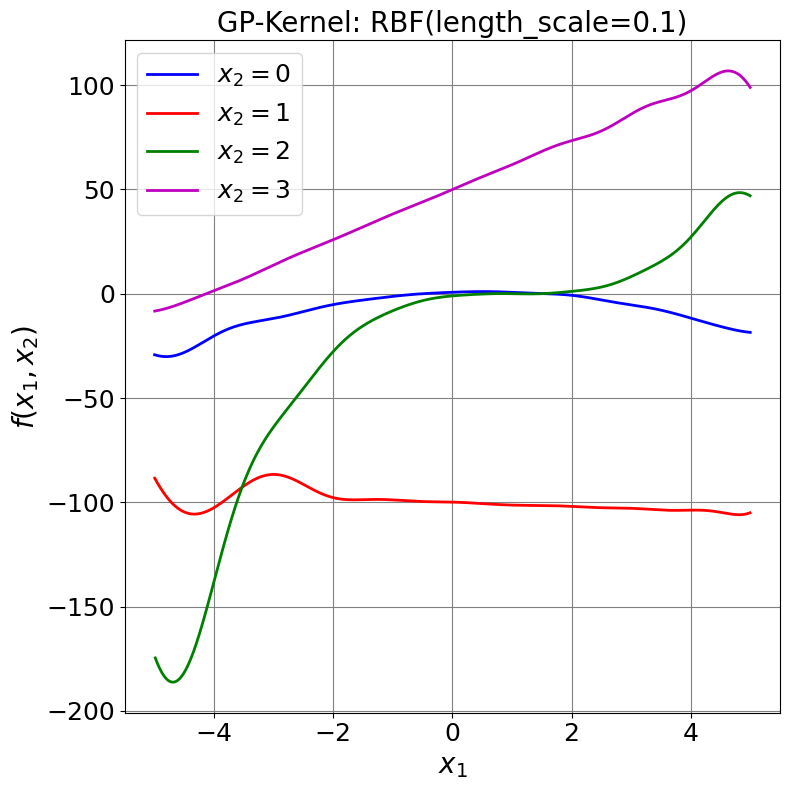

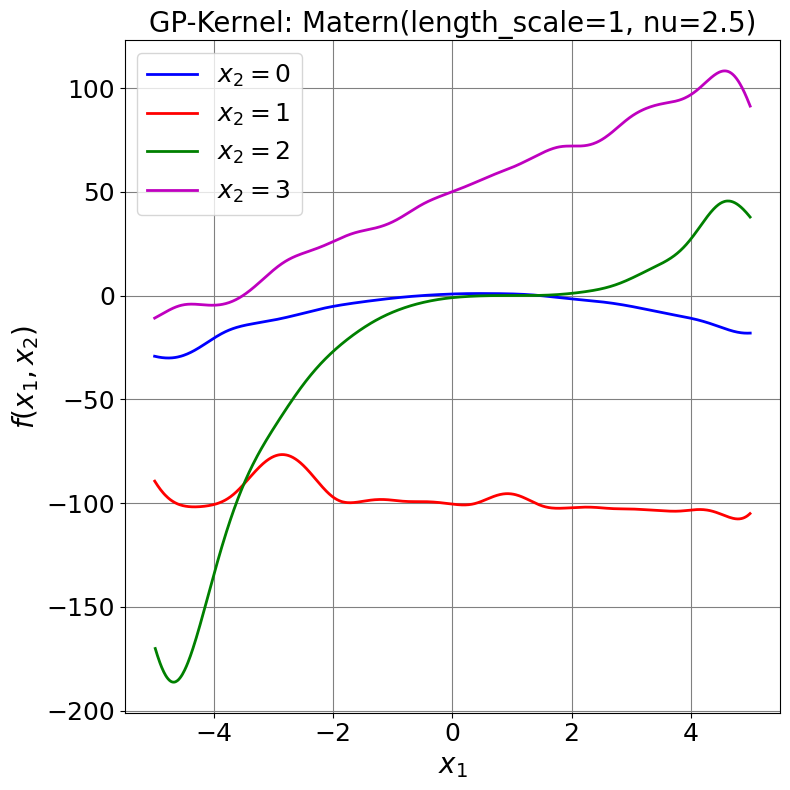

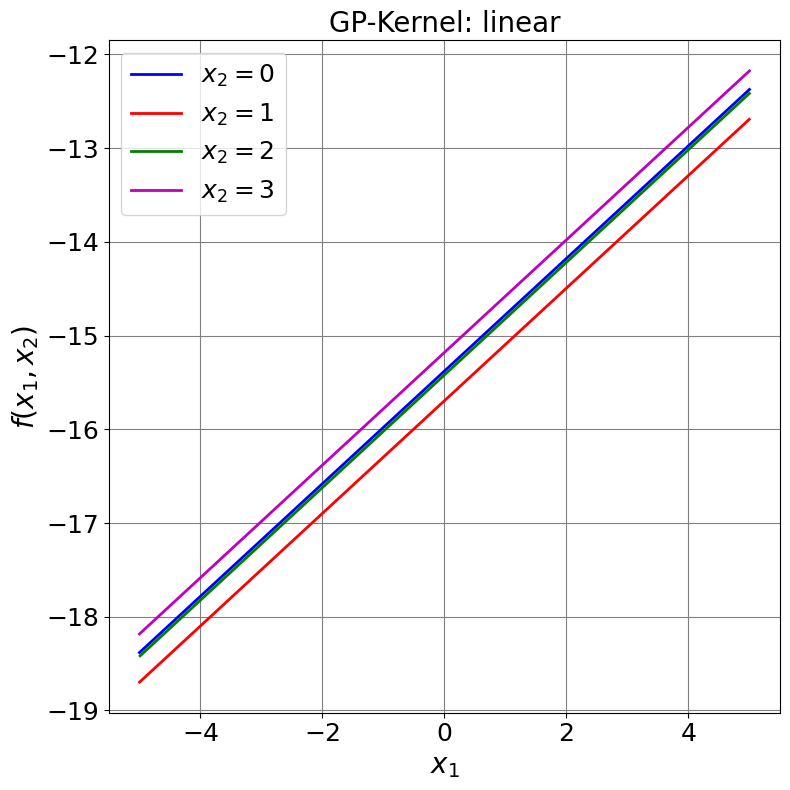

In [11]:
# Plotting the results
# fig = plt.figure(figsize=(10, 15))
for i, (kernel_name, res) in enumerate(results_plot.items()):
    # plt.subplot(3, 2, i + 1)
        if function_to_test in ["fun_1"]:
            fig = plt.figure(figsize=(8, 8))
            plt.plot(x_topredict, res["y_pred"], 'b-', linewidth=2)
            # plt.fill_between(x_topredict.ravel(), 
            #                  res["y_pred"][:N_predict] - 1.96 * res["y_std"][:N_predict], 
            #                  res["y_pred"][:N_predict] + 1.96 * res["y_std"][:N_predict], 
            #                  alpha=0.2, color='blue', label="95% Confidence Interval")
            # plt.fill_between(x_topredict.ravel(), 
            #              res["y_pred"][N_predict:N_predict*2] - 1.96 * res["y_std"][N_predict:N_predict*2], 
            #              res["y_pred"][N_predict:N_predict*2] + 1.96 * res["y_std"][N_predict:N_predict*2], 
            #              alpha=0.2, color='blue', label="95% Confidence Interval")
            if i == 2:
                kernel_name = 'linear'
                
            plt.title(f"Kernel: {kernel_name}", fontsize=20)
            plt.xlabel(r'$x_1$', fontsize=20)
            plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.grid(True, color='gray')
            plt.box(True)
            
        elif function_to_test in ["fun_2"]:
            fig = plt.figure(figsize=(8, 8))
            # Plot for y = 0
            plt.plot(X1_plot[X2_plot==0], res["y_pred"][X2_plot==0], 'b-', label=r'$x_2 = 0$', linewidth=2)
            # Plot for y = 1
            plt.plot(X1_plot[X2_plot==1], res["y_pred"][X2_plot==1], 'r-', label=r'$x_2 = 1$', linewidth=2)
            # Plot for y = 2
            plt.plot(X1_plot[X2_plot==2], res["y_pred"][X2_plot==2], 'g-', label=r'$x_2 = 2$', linewidth=2)
            # Plot for y = 3
            plt.plot(X1_plot[X2_plot==3], res["y_pred"][X2_plot==3], 'm-', label=r'$x_2 = 3$', linewidth=2)
            # plt.fill_between(x_topredict.ravel(), 
            #                  res["y_pred"][:N_predict] - 1.96 * res["y_std"][:N_predict], 
            #                  res["y_pred"][:N_predict] + 1.96 * res["y_std"][:N_predict], 
            #                  alpha=0.2, color='blue', label="95% Confidence Interval")
            # plt.fill_between(x_topredict.ravel(), 
            #              res["y_pred"][N_predict:N_predict*2] - 1.96 * res["y_std"][N_predict:N_predict*2], 
            #              res["y_pred"][N_predict:N_predict*2] + 1.96 * res["y_std"][N_predict:N_predict*2], 
            #              alpha=0.2, color='blue', label="95% Confidence Interval")
            if i == 2:
                kernel_name = 'linear'
                
            plt.title(f"GP-Kernel: {kernel_name}", fontsize=20)
            plt.xlabel(r'$x_1$', fontsize=20)
            plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.grid(True, color='gray')
            plt.box(True)
            plt.legend(fontsize=18)
    
        plt.tight_layout()
        if save_fig:
            fig.savefig(f"{function_to_test}_parc_gp_{kernel_name}_TS_{N}.pdf")
            fig.savefig(f"{function_to_test}_parc_gp_{kernel_name}_TS_{N}.png")
        plt.show()

# plt.tight_layout()
# fig.savefig("parc_gp_surrogate_fun_example_2.pdf")
# fig.savefig("parc_gp_surrogate_fun_example_2.png")
# plt.show()

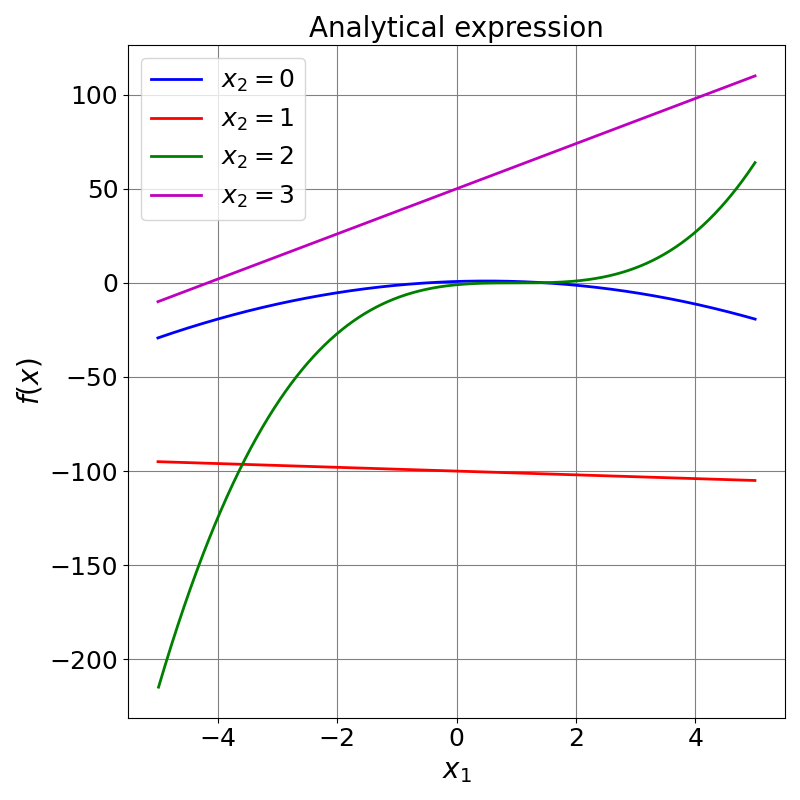

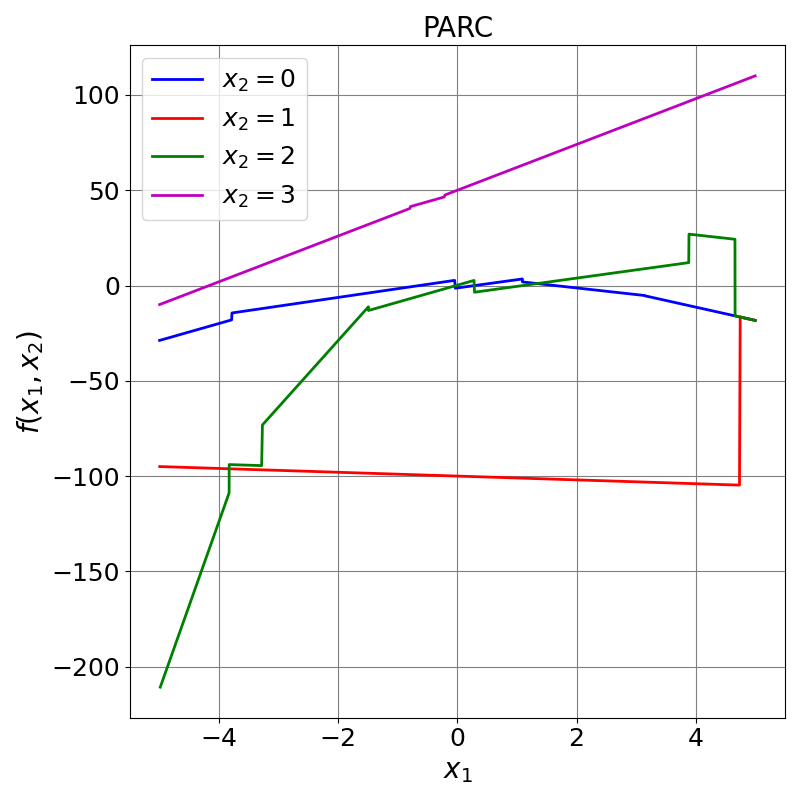

In [12]:
from IPython.display import Image, display
display(Image(filename=f"{function_to_test}_parc_analytical_fun.png"))
display(Image(filename=f"{function_to_test}_parc_pwa_TS_{N}.png"))